In [1]:
# install the Keras-tuner library
!pip install keras-tuner

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)


import matplotlib.pyplot as plt # plotting library
%matplotlib inline
from IPython.display import display
from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import utils
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense , Activation, Dropout, Flatten
from keras.utils import np_utils

In [3]:
# install the Keras-tuner library
!pip install keras-tuner
# import the library and refer to it as kt
import kerastuner as kt

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  after removing the cwd from sys.path.


In [4]:
# load the mnist dataset from keras
import tensorflow as tf
from tensorflow.keras import datasets
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

In [5]:
# data pre-processing - we need to reshape to specify a channel of 1 on the end of the
# data to signify that there is one channel as it is a grayscale image
x_train = x_train.reshape(60000,28,28,1)
x_test = x_test.reshape(10000,28,28,1)

# resize and normalize
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# one-hot encode the train and test target columns
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [6]:
# create the model
from keras.models import Sequential
from keras.layers import Dense
# create a regularizer object
from tensorflow.keras import regularizers # import the regularizers module
reg = regularizers.l2(l2=0.01)
def model_builder(hp):
  model = Sequential() 
  model.add(Flatten(input_shape=(x_train.shape[1:])))
  hp_units = hp.Int('hidden_layer_1_units', min_value = 32, max_value = 512, step = 32)
  model.add(Dense(hp_units, activation ='relu',kernel_regularizer=reg))
  model.add(Dropout(0.2))
  model.add(Dense(10, activation='softmax'))
  #model.summary()
  # compiling the model
  hp_learning_rate = hp.Choice('learning_rate', values = [1e-1,1e-2, 1e-3, 1e-4]) 
  # create the Adam optimiser, specifying the variable learning rate
  opt = tf.keras.optimizers.Adam(learning_rate = hp_learning_rate)
  model.compile(optimizer = opt, loss='categorical_crossentropy', metrics=['accuracy'])
  return model

In [7]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(60000, 28, 28, 1)
(60000, 10)
(10000, 28, 28, 1)
(10000, 10)


In [8]:
# instatiate the tuner and perform hypertuning
tuner = kt.Hyperband(model_builder,
                     objective = 'val_accuracy', 
                     max_epochs = 10,
                     factor = 3,        # factor is a number that determines how many models are created to run in parallel whaen testing the hyperparameters
                     directory = 'my_dir',  # directory that the tuned hyperparameter results are stored in (change the name of this directory if you get the message INFO:tensorflow:Oracle triggered exit)
                     project_name = 'intro_to_kt') 

INFO:tensorflow:Reloading Oracle from existing project my_dir/intro_to_kt/oracle.json
INFO:tensorflow:Reloading Tuner from my_dir/intro_to_kt/tuner0.json


In [9]:
# define a callback to clear the training outputs at the end of every training step
class ClearTrainingOutput(tf.keras.callbacks.Callback):
  def on_train_end(*args, **kwargs):
    IPython.display.clear_output(wait = True)

In [10]:
import IPython
# run the hyperparameter search
tuner.search(x_train, y_train, epochs = 10, validation_data = (x_test, y_test), callbacks = [ClearTrainingOutput()])

INFO:tensorflow:Oracle triggered exit


In [11]:
# print out the hyperparameters keras tuner has determined to be the best values
best_hps = tuner.get_best_hyperparameters()[0]
print(best_hps.values)

{'hidden_layer_1_units': 448, 'learning_rate': 0.0001, 'tuner/epochs': 10, 'tuner/initial_epoch': 0, 'tuner/bracket': 0, 'tuner/round': 0}


In [12]:
# set the model to have the optimum hyperparameters and print the summary so we can see the 
model = tuner.hypermodel.build(best_hps)
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 784)               0         
                                                                 
 dense_2 (Dense)             (None, 448)               351680    
                                                                 
 dropout_1 (Dropout)         (None, 448)               0         
                                                                 
 dense_3 (Dense)             (None, 10)                4490      
                                                                 
Total params: 356,170
Trainable params: 356,170
Non-trainable params: 0
_________________________________________________________________


In [13]:
# train the model as usual
history = model.fit(x_train, y_train, epochs =60, validation_data = (x_test, y_test))

Epoch 1/60
1875/1875 [==============================] - 19s 10ms/step - loss: 2.6920 - accuracy: 0.7753 - val_loss: 1.1950 - val_accuracy: 0.8197
Epoch 2/60
1875/1875 [==============================] - 14s 7ms/step - loss: 0.8877 - accuracy: 0.8254 - val_loss: 0.7179 - val_accuracy: 0.8279
Epoch 3/60
1875/1875 [==============================] - 12s 6ms/step - loss: 0.6523 - accuracy: 0.8318 - val_loss: 0.6136 - val_accuracy: 0.8315
Epoch 4/60
1875/1875 [==============================] - 11s 6ms/step - loss: 0.5899 - accuracy: 0.8356 - val_loss: 0.5969 - val_accuracy: 0.8227
Epoch 5/60
1875/1875 [==============================] - 12s 6ms/step - loss: 0.5634 - accuracy: 0.8393 - val_loss: 0.5718 - val_accuracy: 0.8302
Epoch 6/60
1875/1875 [==============================] - 12s 6ms/step - loss: 0.5470 - accuracy: 0.8408 - val_loss: 0.5478 - val_accuracy: 0.8374
Epoch 7/60
1875/1875 [==============================] - 11s 6ms/step - loss: 0.5358 - accuracy: 0.8430 - val_loss: 0.5562 - val_a

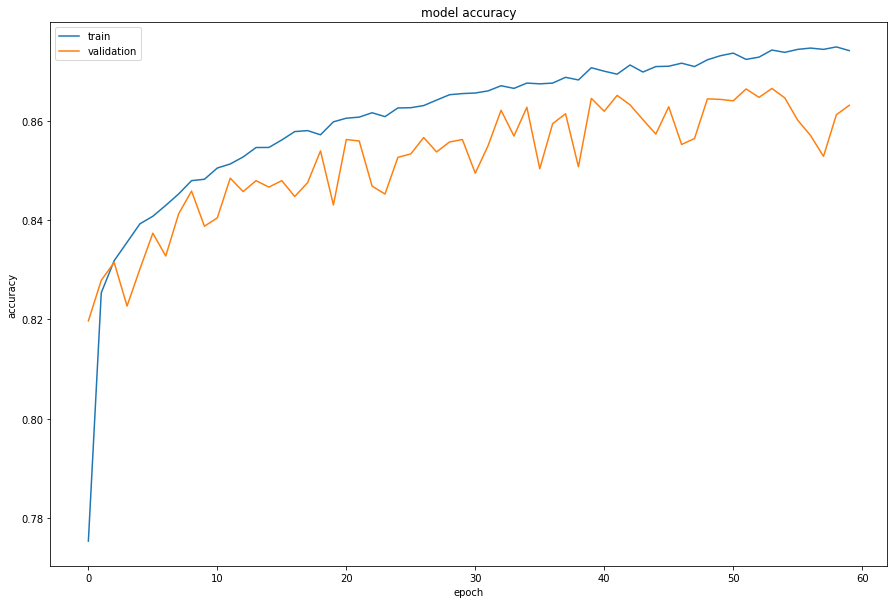

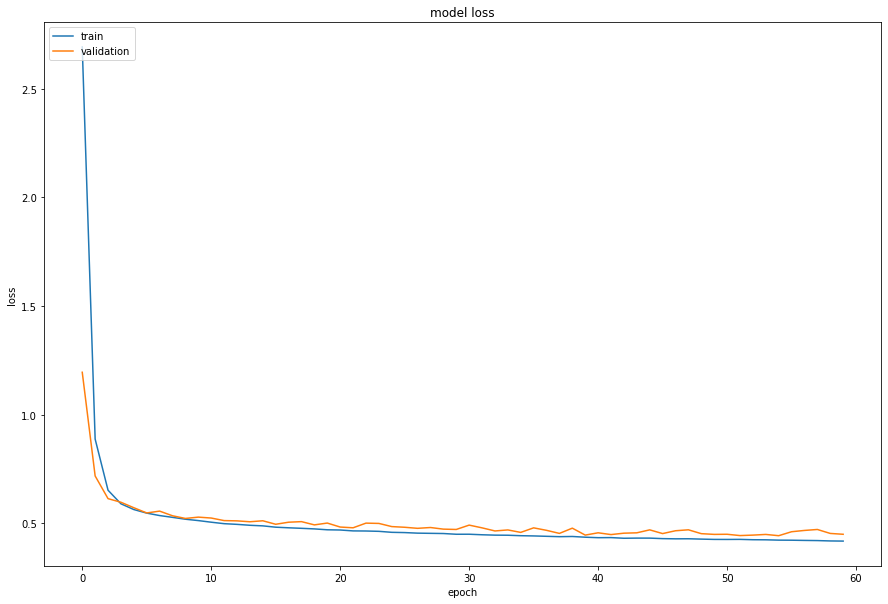

In [16]:
# plot the history of the training
import matplotlib.pyplot as plt

# summarize the history for accuracy
plt.figure(figsize=(15,10))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','validation'], loc='upper left')
plt.show()

# summarize the history for loss
plt.figure(figsize=(15,10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','validation'], loc='upper left')
plt.show()